In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import pickle

In [2]:
# Read table with (simplified) horizon symbols
#path_horizons_simple = '..\\..\\..\\..\\data\\BGR_mini\\Vereinfachung_Horizontsymbole.csv'
path_horizons_simple = "../data/BGR/Vereinfachung_Horizontsymbole.csv"
df_simple = pd.read_csv(path_horizons_simple)
df_simple.rename(columns={"relevanter Anteil = was sinntragend und detektierbar ist - es sind nicht alles gültige Symbole": "relevanter Anteil"}, inplace=True)
df_simple.head()

Horiz  Anzahl im Datensatz relevanter Anteil stark vereinfacht
0    Ap                 1762                Ap                Ap
1    Bv                  626                Bv                Bv
2  ilCv                  620               ilC                Cv
3  elCv                  500               elC                Cv
4    Ah                  455                Ah                Ah

In [3]:
# Filter for symbols with at least n samples
df_simple = df_simple[df_simple['Anzahl im Datensatz'] > 10]
unique_labels = df_simple['relevanter Anteil'].unique()
len(unique_labels)

100

In [4]:
# Replace all '+' with '-'
unique_labels = [label.replace('+', '-') if '+' in label else label for label in unique_labels]

# Order in horizon mixtures should not matter
seen = set()
result = []
for label in unique_labels:
    parts = label.split('-')
    key = tuple(sorted(parts)) 

    if key not in seen:
        seen.add(key)
        result.append(label)
unique_labels = result

In [5]:
len(unique_labels)

87

In [6]:
sorted(unique_labels)

['Acp',
 'Acxh',
 'Aeh',
 'Ael',
 'Ael-Bt',
 'Aep',
 'Ah',
 'Ah-Bv',
 'Al',
 'Al-Bt',
 'Al-Bv',
 'Al-Sw',
 'Ap',
 'Axh',
 'Axp',
 'Bcv',
 'Bh',
 'Bhs',
 'Bhv',
 'Bs',
 'Bsh',
 'Bsv',
 'Bt',
 'Bt-Sd',
 'Btv',
 'Bv',
 'Bv-Ael',
 'Bv-Cv',
 'Bv-elC',
 'Bv-ilC',
 'Bvt',
 'C',
 'Cbtv',
 'Cj',
 'Cv',
 'E',
 'Gkso',
 'Go',
 'Go-ilC',
 'Gor',
 'Gr',
 'Gro',
 'Gw',
 'Hr',
 'Hv',
 'Hw',
 'M',
 'M-Go',
 'M-Gro',
 'Mc',
 'P',
 'P-Sd',
 'R',
 'Sd',
 'Sd-Btv',
 'Sd-Bv',
 'Sd-ilC',
 'Sd-lC',
 'Ssw',
 'Sswd',
 'Sw',
 'Sw-Ah',
 'Sw-Ap',
 'Sw-Bt',
 'Sw-Bv',
 'Sw-Go',
 'Sw-M',
 'Sw-ilC',
 'aelC',
 'bE',
 'cC',
 'clC',
 'cmC',
 'elC',
 'elC-P',
 'elCc',
 'emC',
 'iC',
 'ilC',
 'ilCbtv',
 'imC',
 'imCv',
 'lC',
 'mCv',
 'tGo',
 'tGr',
 'tGro']

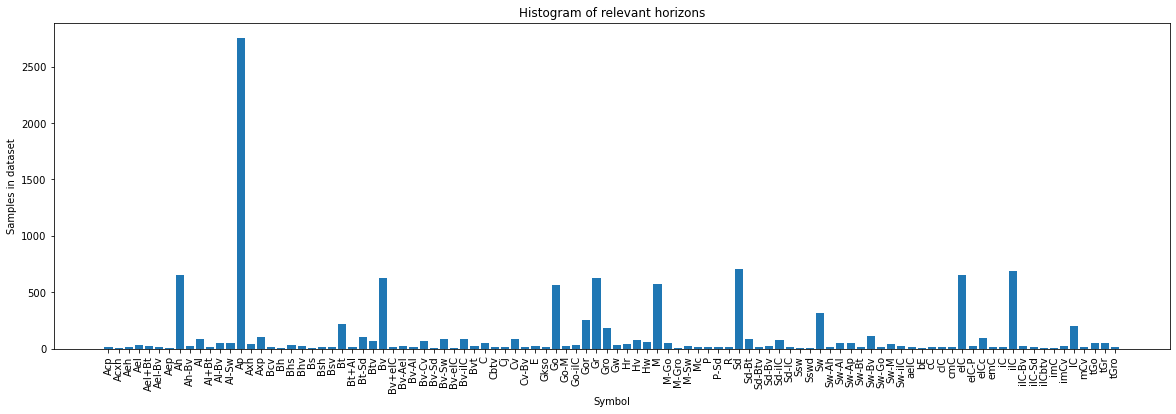

In [7]:
# Histogram of unique labels
label_counts = df_simple.groupby('relevanter Anteil')['Anzahl im Datensatz'].sum()

plt.figure(figsize=(20,6))
plt.bar(label_counts.index, label_counts)
plt.xlabel('Symbol')
plt.ylabel('Samples in dataset')
plt.title('Histogram of relevant horizons')
plt.xticks(rotation=90)
plt.show()

In [8]:
# Define the taxonomy as a graph
taxonomy = nx.DiGraph()

# A Horizons subcategories
a_horizons = ["Ap", "Ah", "Al", "Axp", "Axh", "Acp", "Aep", "Aeh", "Ael", "Acxh"]
for label in a_horizons:
    taxonomy.add_edge("A", label)

# B Horizons subcategories
b_horizons = ["Bv", "Bt", "Bhs", "Bh", "Bs", "Bhv", "Btv", "Bsh", "Bcv", "Bsv", "Bvt"]
for label in b_horizons:
    taxonomy.add_edge("B", label)

# C Horizons subcategories
c_horizons = ["C.", "Cv", "Cbtv", "Cj", "cC", "clC", "iC", "ilC", "lC", "ilCbtv", "elC", "emC", "imC", "mCv", "imCv", "cmC", "elCc", "aelC"]
for label in c_horizons:
    taxonomy.add_edge("C", label)

# E Horizons subcategories
e_horizons = ["E.", "bE"]
for label in e_horizons:
    taxonomy.add_edge("E", label)

# G Horizons subcategories
g_horizons = ["Gr", "Gro", "Gor", "Go", "Gw", "tGo", "tGr", "tGro", "Gkso"]
for label in g_horizons:
    taxonomy.add_edge("G", label)

# H Horizons subcategories
h_horizons = ["Hr", "Hw", "Hv"]
for label in h_horizons:
    taxonomy.add_edge("H", label)

# M Horizons subcategories
m_horizons = ["M.", "Mc"]
for label in m_horizons:
    taxonomy.add_edge("M", label)

# P Horizon
taxonomy.add_edge("P", "P.")

# R Horizon
taxonomy.add_edge("R", "R.")

# S Horizons subcategories
s_horizons = ["Sd", "Sw", "Ssw", "Sswd"]
for label in s_horizons:
    taxonomy.add_edge("S", label)

In [9]:
# Extend graph with mixtures (26 in total)
mixture_labs = []
for lab in unique_labels:
    if '-' in lab:
        mixture_labs.append(lab)
        print(lab)
        parents = lab.split('-')
        for parent in parents:
            # Two parent nodes for a mixture
            taxonomy.add_edge(parent, lab)
            # Is one of the parents' labels also a terminal node? 
            if parent in unique_labels:
                taxonomy.add_edge(parent, parent + '.')

Sw-Bv
Bv-ilC
Bt-Sd
Bv-Cv
Sd-ilC
Al-Sw
Al-Bv
M-Go
Ael-Bt
Ah-Bv
Sw-M
Sw-Ap
Bv-Ael
Go-ilC
elC-P
Sd-Bv
Sw-ilC
Al-Bt
Sw-Ah
P-Sd
Sd-lC
Sw-Go
Sw-Bt
Sd-Btv
Bv-elC
M-Gro


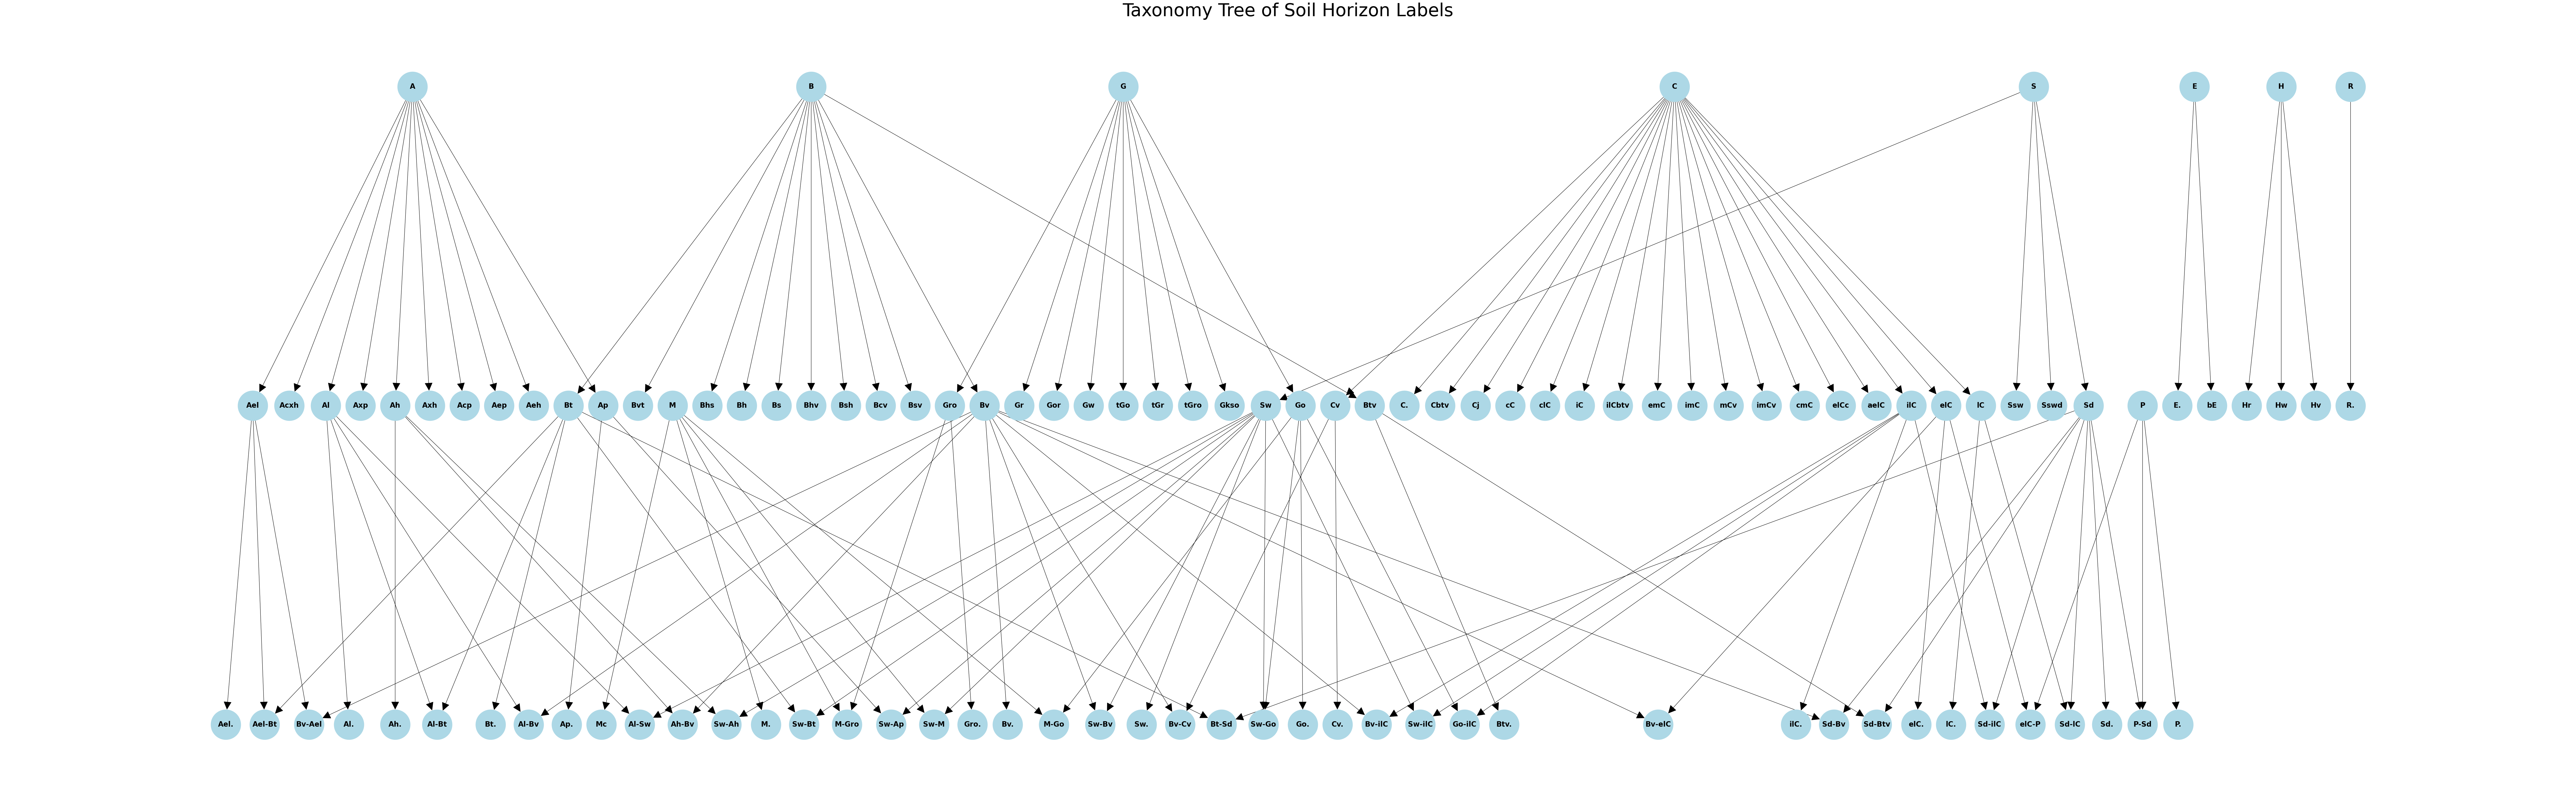

In [23]:
# Note: Bindestrich '-' heißt Übergangshorizont (evtl vermischt vom ersten zum zweiten)
#       Plus '+' heißt Verzahnungshorizont (zwischen dem ersten und dem zweiten, ohne Vermischung)

# Create the plot
fig = plt.figure(figsize=(100, 30))
pos = nx.nx_agraph.graphviz_layout(taxonomy, prog="dot")

# Draw the graph
nx.draw(taxonomy, pos, with_labels=True, arrows=True, node_size=7000, node_color="lightblue", 
        font_size=20, font_weight="bold", arrowsize=50)

plt.title("Taxonomy Tree of Soil Horizon Labels", fontsize=50)
plt.show()
fig.savefig("..\\..\\figures\\horizons_tree.pdf")

In [10]:
# Total number of nodes (counting abstract parent that don't have realizations in the horizon symbols)
len(taxonomy.nodes())

112

In [11]:
# Number of terminal nodes (same as in unique_labels)
len([x for x in taxonomy.nodes() if taxonomy.out_degree(x)==0])

87

### Compute Graph Embeddings

##### Node2Vec

In [7]:
# Embed graph into vector space
from node2vec import Node2Vec # current newest version 0.5.0

# Initialize Node2Vec
node2vec = Node2Vec(taxonomy, dimensions=len(unique_labels), walk_length=30, num_walks=200)

Computing transition probabilities:   0%|          | 0/112 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████| 200/200 [00:00<00:00, 1724.11it/s]


In [27]:
# Fit the model and generate embeddings
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [28]:
# Access embeddings for each node
embeddings = {node: model.wv[node] for node in taxonomy.nodes()}

# Example: Get embedding for node 'Al-Bv'
al_bv_embedding = embeddings['Al-Bv']
print("Embedding for 'Al-Bv':", al_bv_embedding)

Embedding for 'Al-Bv': [-1.89433377e-02  1.82506721e-02  1.65638572e-03  1.90217863e-03
  1.08482409e-02 -3.88446287e-03  7.45358775e-05  7.55511504e-03
  1.10940654e-02  1.14906975e-03  1.67525897e-03  6.29573828e-03
 -8.01129453e-03 -1.25924721e-02  9.87870153e-03  8.65589548e-03
 -4.28480469e-03  1.42649433e-03  1.90060222e-04 -5.96296694e-03
 -9.87867475e-04 -7.22150458e-03  1.13895200e-02 -1.76039257e-03
 -1.16018467e-02 -1.37225736e-03 -6.49548718e-04  1.04325609e-02
  9.55481781e-04  5.18253446e-03  6.30480843e-03 -2.89504020e-03
  1.11450376e-02  3.64858494e-03 -6.53644977e-03 -1.04335174e-02
 -4.04110504e-03 -8.82386602e-03  9.33206081e-03 -5.20543987e-03
 -5.93432691e-03  2.41192314e-03  1.14430289e-03  7.15199485e-03
 -7.83552043e-03  6.68535533e-04 -6.25260524e-04  1.33632086e-02
  5.51412906e-03  4.91287559e-03  1.01590790e-02 -8.63301009e-03
  2.42372323e-03 -5.42109320e-03 -5.50369779e-03 -1.23382965e-02
 -7.76648195e-03  8.76486208e-03  2.74227117e-03 -2.12217378e-03
 -

In [29]:
# Remove abstract nodes that are not represented as samples in the dataset
# Normalize the others to length 1
for x in taxonomy.nodes():
    if taxonomy.out_degree(x)!=0:
        embeddings.pop(x)
    else:
        embeddings[x] = embeddings[x] / np.linalg.norm(embeddings[x])
embeddings

{'Axp': array([ 0.09902859, -0.01312326, -0.17030482,  0.14848803, -0.04145375,
         0.14101802, -0.14290993,  0.1677243 , -0.09922789,  0.10707502,
         0.15143526,  0.06280277, -0.03417123, -0.08964015, -0.15850513,
         0.06521544,  0.12771483, -0.11819537,  0.09473062,  0.11224866,
        -0.14913003,  0.03809225, -0.08962376, -0.09523395, -0.00669084,
        -0.12299015, -0.05698806, -0.10618431, -0.0957309 , -0.135748  ,
         0.18971734,  0.13991266,  0.00941624, -0.04979553,  0.08731192,
        -0.00469255, -0.14252691, -0.13621229,  0.04653256,  0.15905458,
         0.05472948,  0.15155768,  0.11177012,  0.00980399,  0.12277271,
         0.1506149 ,  0.10499983,  0.19755326, -0.13554162,  0.00636987,
        -0.09002524, -0.12319401, -0.10663666,  0.07131524,  0.00640475,
        -0.16068286,  0.11782043,  0.11959288,  0.07751738,  0.12232802,
        -0.11073576, -0.10358652,  0.04043612, -0.1048774 , -0.11868748,
         0.10618278, -0.11477053, -0.0700580

In [35]:
# Create mappings index-to-label for consistency with the embedding dictionary HCE
ind2label_list, label2ind_dict = [], {}
for i, lab in enumerate(embeddings):
    ind2label_list.append(lab)
    label2ind_dict[lab] = i

emb_dict_node2vec = {'ind2label': ind2label_list, 'label2ind': label2ind_dict, 'embedding': np.array(list(embeddings.values()))}

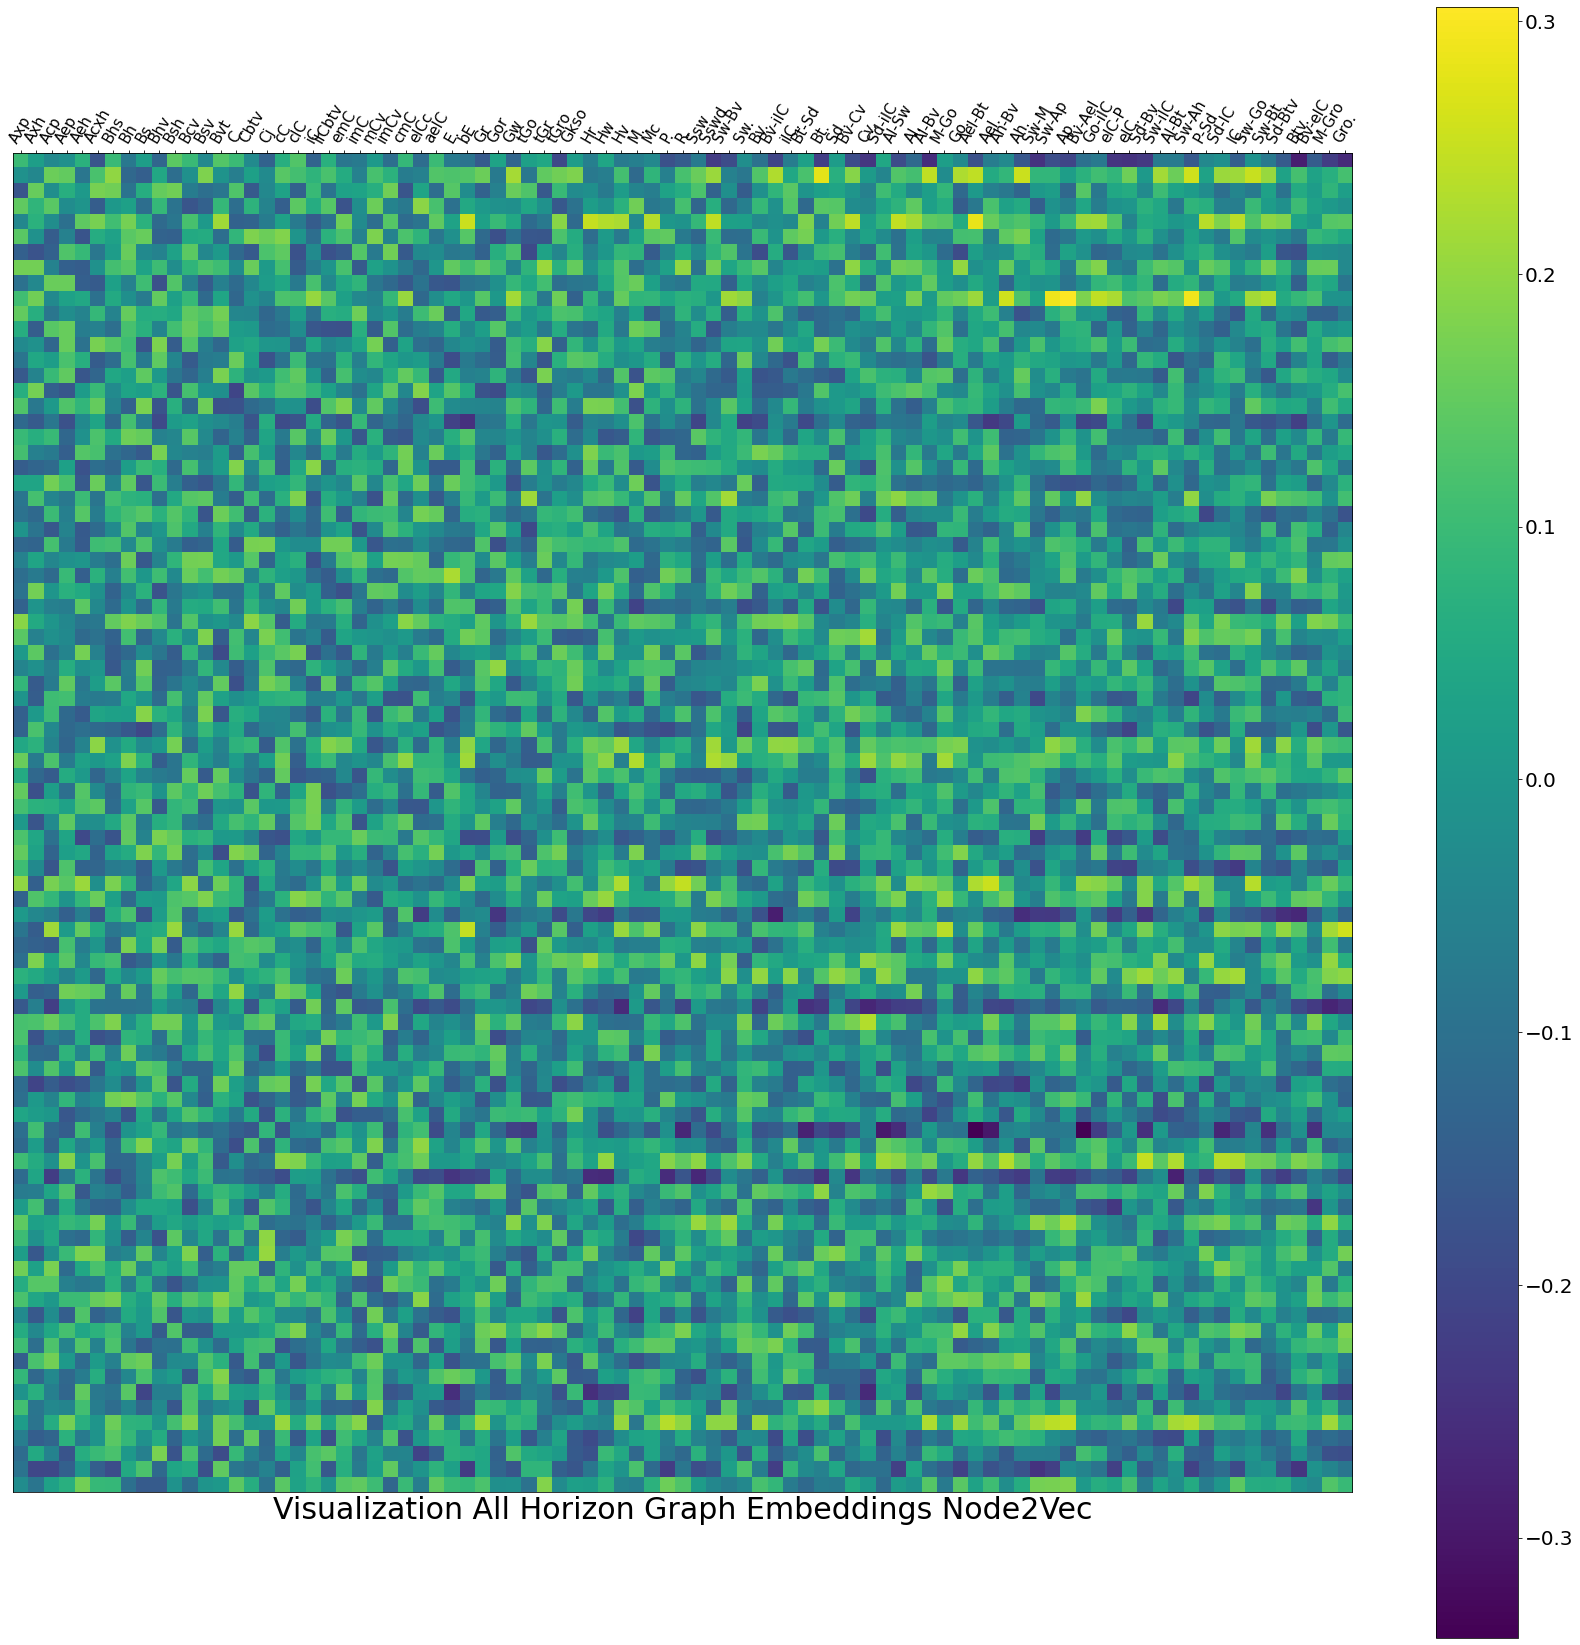

In [42]:
figsize = 30
fontsize = 30
plt.figure(figsize=(figsize,figsize))
plt.imshow(emb_dict_node2vec['embedding'].T)
plt.xticks(np.arange(len(emb_dict_node2vec['ind2label'])), emb_dict_node2vec['ind2label'], rotation=60, fontsize=fontsize-15)
plt.gca().xaxis.set_ticks_position('top')
plt.xlabel('Visualization All Horizon Graph Embeddings Node2Vec', fontsize=fontsize)
plt.yticks([])
cbar = plt.colorbar(); cbar.ax.tick_params(labelsize=fontsize-10)
plt.show()

In [43]:
# Store emb. dictionary
with open('./BGR/label_embeddings/node2vec_all_horizons_embeddings.pickle', 'wb') as handle:
    pickle.dump(emb_dict_node2vec, handle, protocol=pickle.HIGHEST_PROTOCOL)

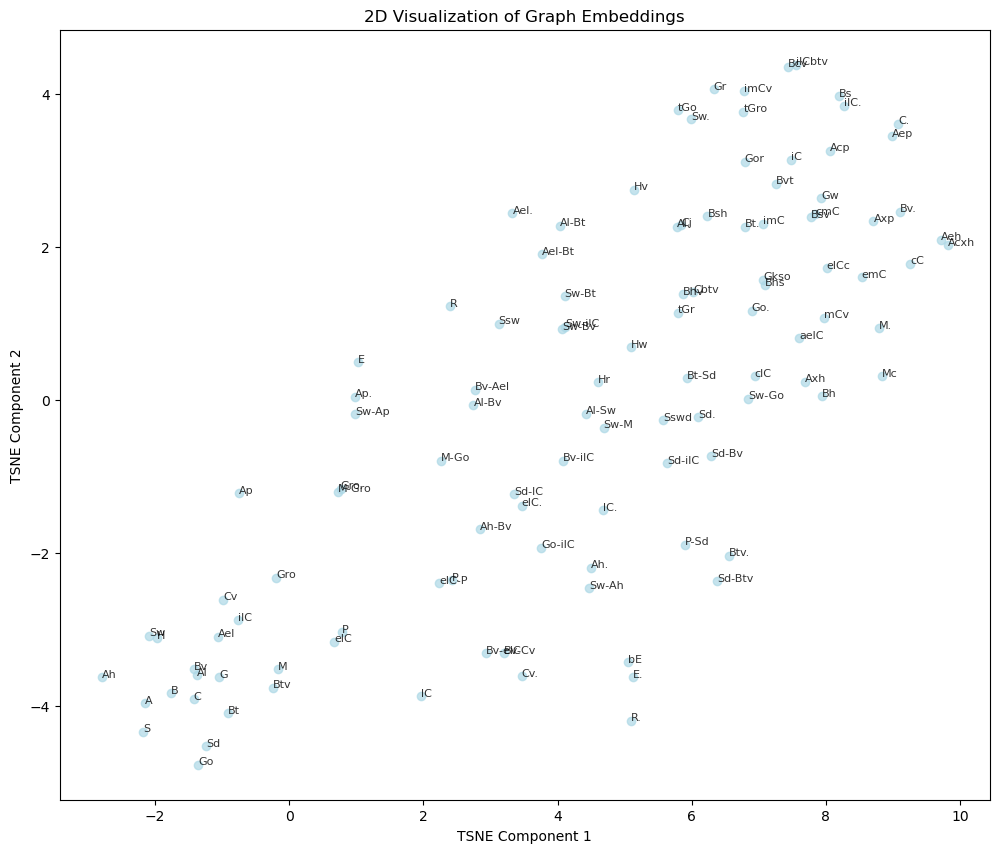

In [15]:
# Extract embeddings and corresponding labels
nodes = list(taxonomy.nodes())
embeddings = np.asarray([model.wv[node] for node in nodes])

# Reduce dimensions to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Plot the embeddings
plt.figure(figsize=(12, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7, c="lightblue")

# Annotate each point with its label
for i, label in enumerate(nodes):
    plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label, fontsize=8, alpha=0.8)
plt.title("2D Visualization of Graph Embeddings")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.show()

##### HCE

https://github.com/cvjena/semantic-embeddings

In [61]:
#with open('./BGR/main_horizons_embeddings.pickle', 'rb') as handle:
with open('..\\..\\main_horizons_embeddings.pickle', 'rb') as handle:
    emb_dict = pickle.load(handle)

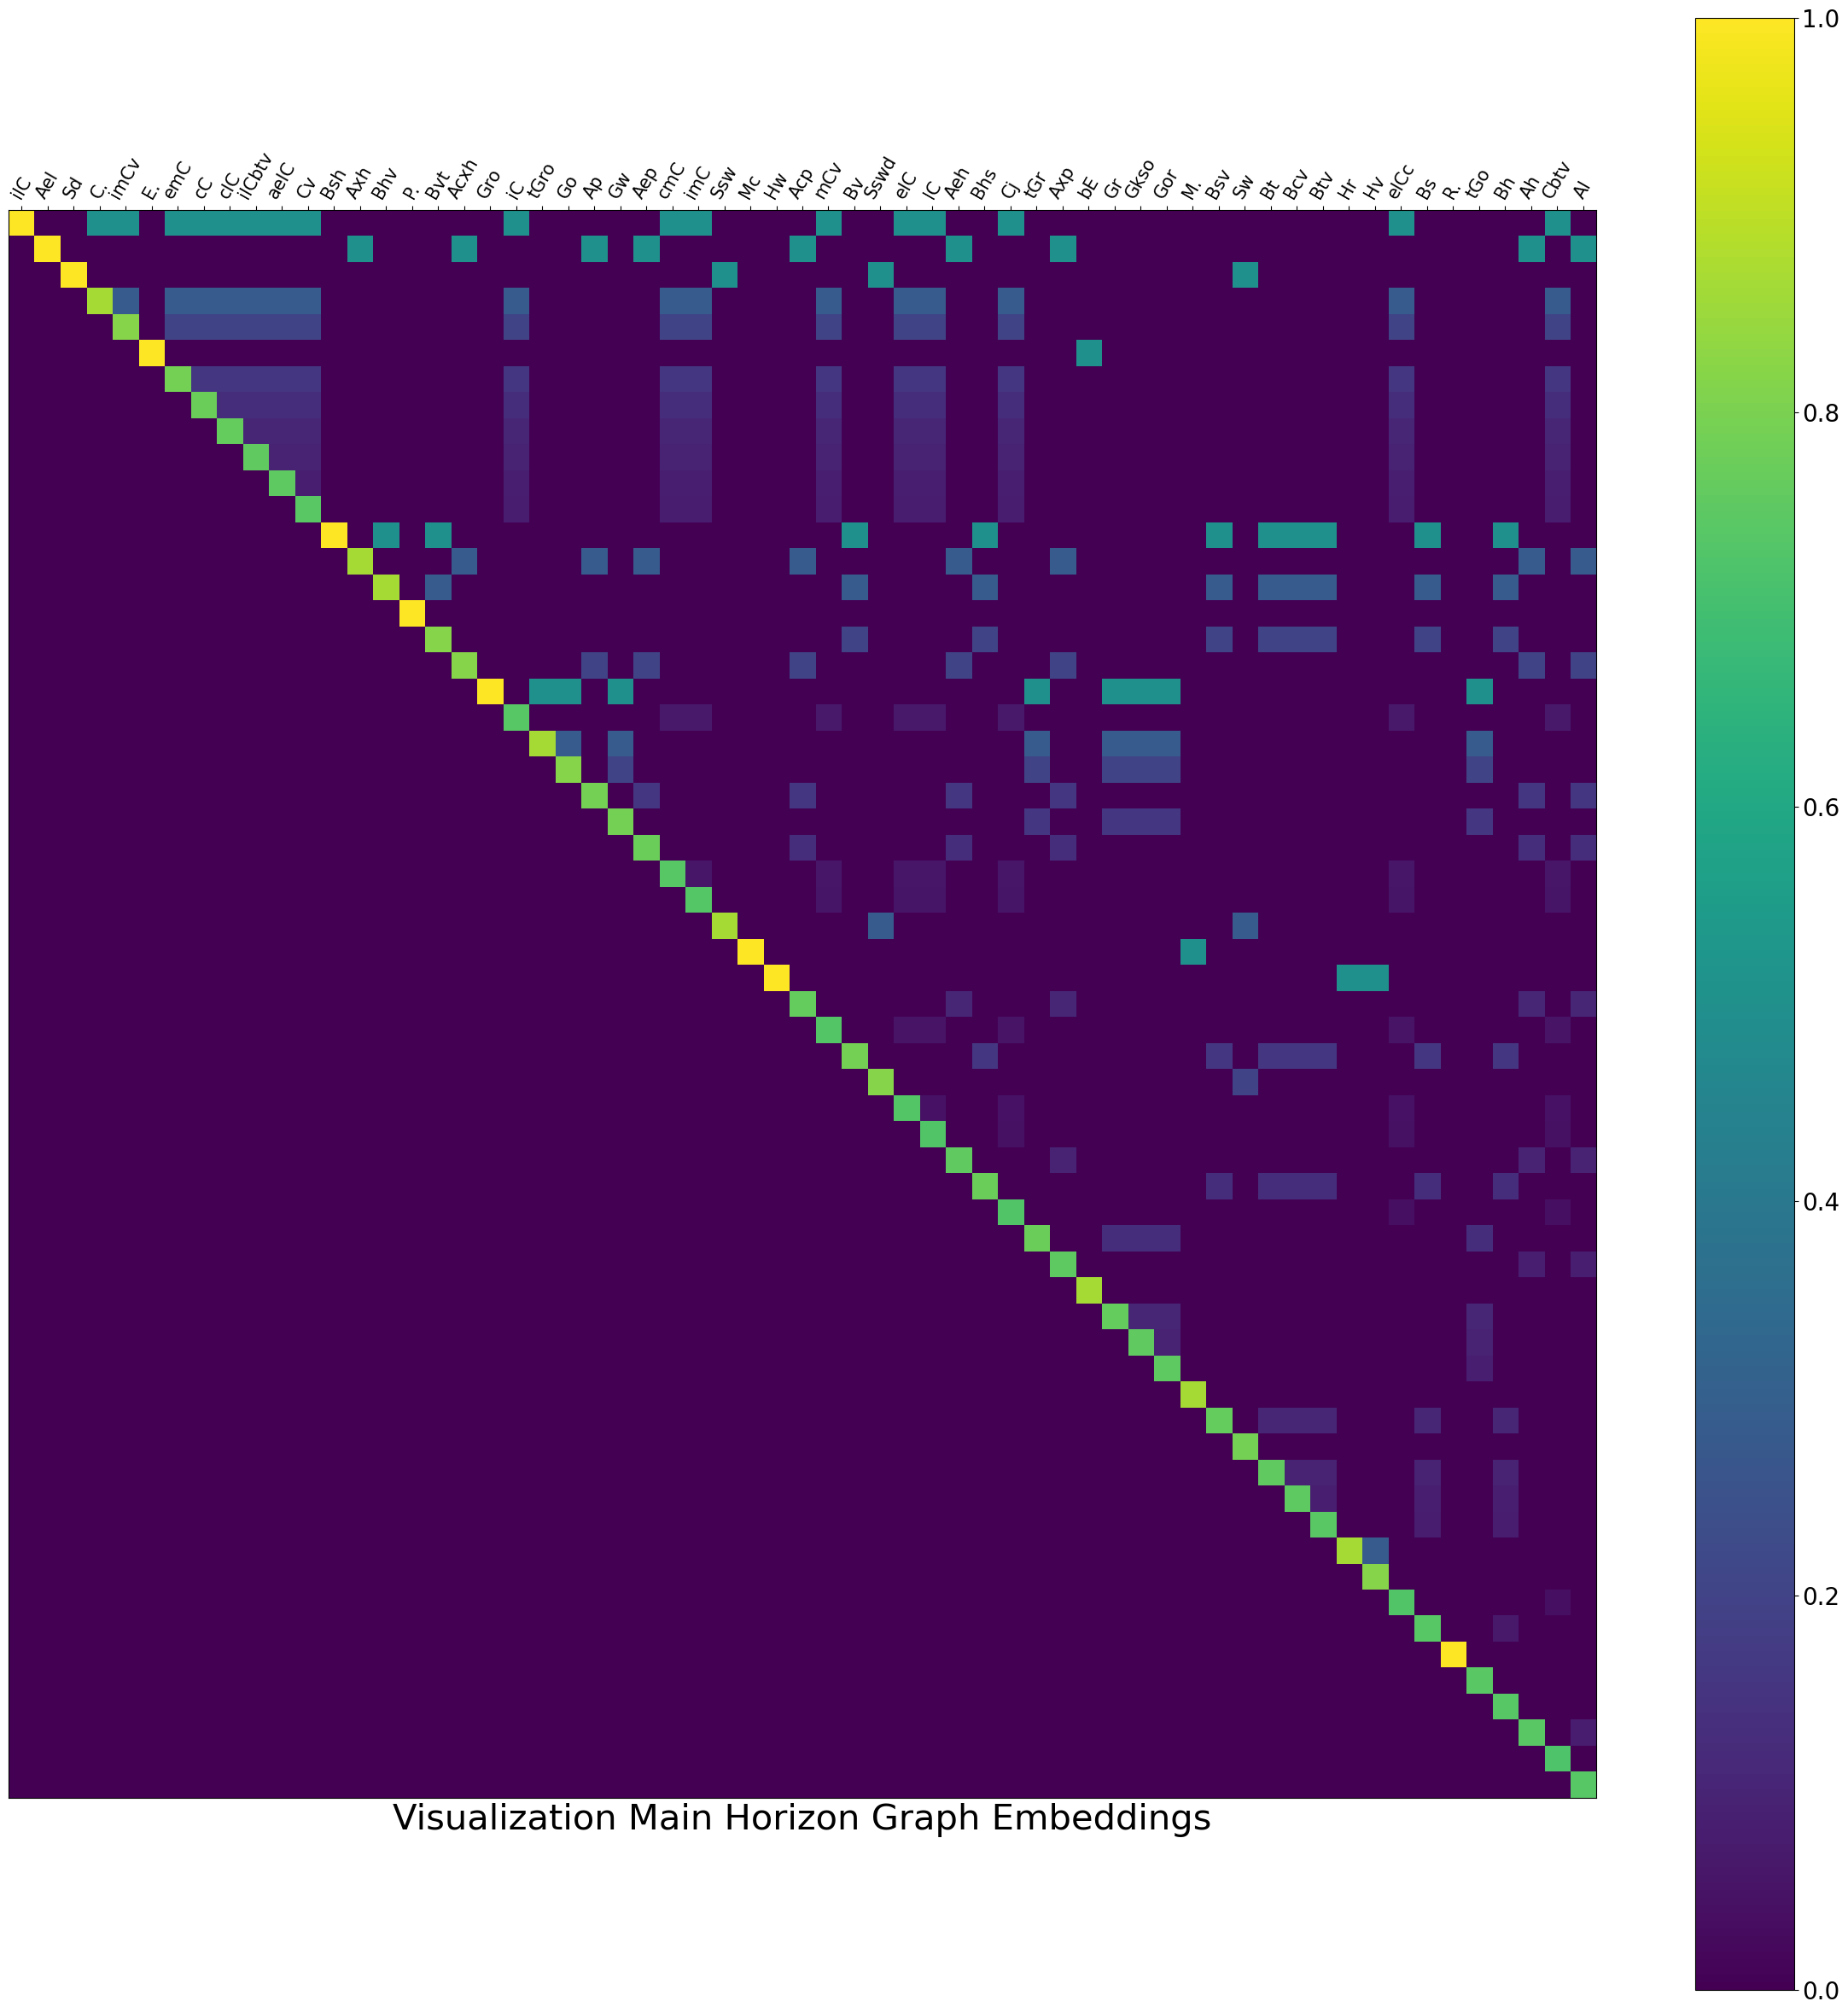

In [62]:
figsize = 30
fontsize = 30
plt.figure(figsize=(figsize,figsize))
plt.imshow(emb_dict['embedding'].T)
plt.xticks(np.arange(len(emb_dict['ind2label'])), emb_dict['ind2label'], rotation=60, fontsize=fontsize-15)
plt.gca().xaxis.set_ticks_position('top')
plt.xlabel('Visualization Main Horizon Graph Embeddings', fontsize=fontsize)
plt.yticks([])
cbar = plt.colorbar(); cbar.ax.tick_params(labelsize=fontsize-10)
plt.show()

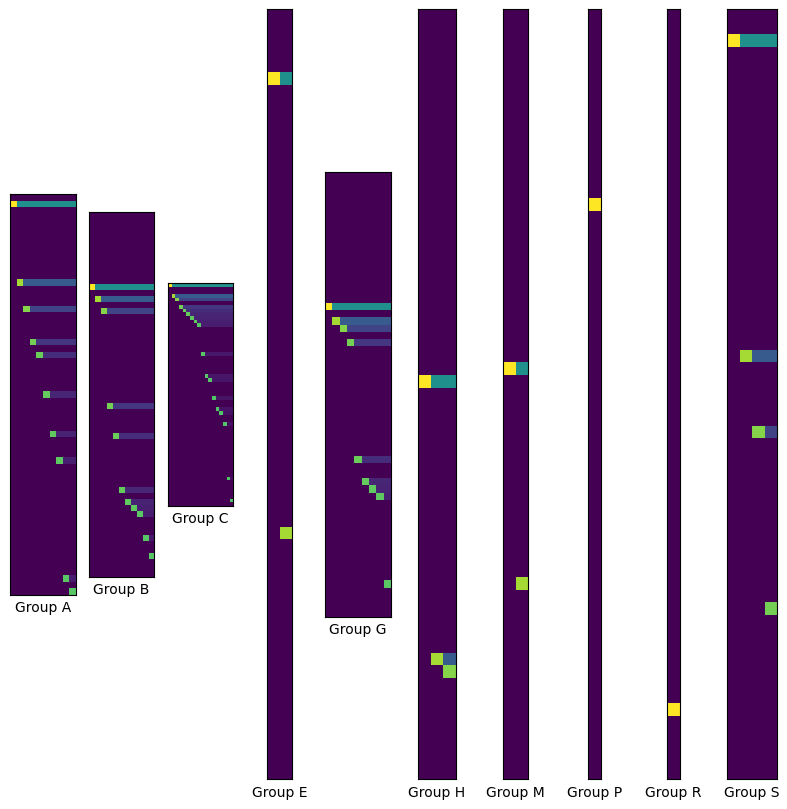

In [44]:
figsize = 10
fontsize = 10
main_labs = ['A', 'B', 'C', 'E', 'G', 'H', 'M', 'P', 'R', 'S']
plt.figure(figsize=(figsize,figsize))
for i, lab in enumerate(main_labs):
    ind = np.where([lab in emb_dict['ind2label'][i] for i in range(len(emb_dict['ind2label']))])
    plt.subplot(1, len(main_labs), i+1)
    plt.imshow(emb_dict['embedding'][ind].T)
    plt.xlabel('Group ' + lab, fontsize=fontsize)
    plt.xticks([]);plt.yticks([])
plt.show()

In [63]:
for m_lab in mixture_labs:
    parent1, parent2 = m_lab.split('-')
    if len(parent1) == 1: parent1 += '.' # the main Symbols occuring without suffixes or prefixes are marked with a fullstop
    if len(parent2) == 1: parent2 += '.'
    ind_parent1, ind_parent2 = emb_dict['label2ind'][parent1], emb_dict['label2ind'][parent2]
    # Mean of both parent vectors (can be weighted differently), then normalized
    vec_mixture = (emb_dict['embedding'][ind_parent1] + emb_dict['embedding'][ind_parent2]) / 2
    vec_mixture = vec_mixture / np.linalg.norm(vec_mixture)
    # Add new mixture item to the embedding dict
    emb_dict['ind2label'].append(m_lab)
    emb_dict['label2ind'][m_lab] = len(emb_dict['label2ind'])
    emb_dict['embedding'] = np.vstack([emb_dict['embedding'], vec_mixture])
np.shape(emb_dict['embedding'])

(87, 61)

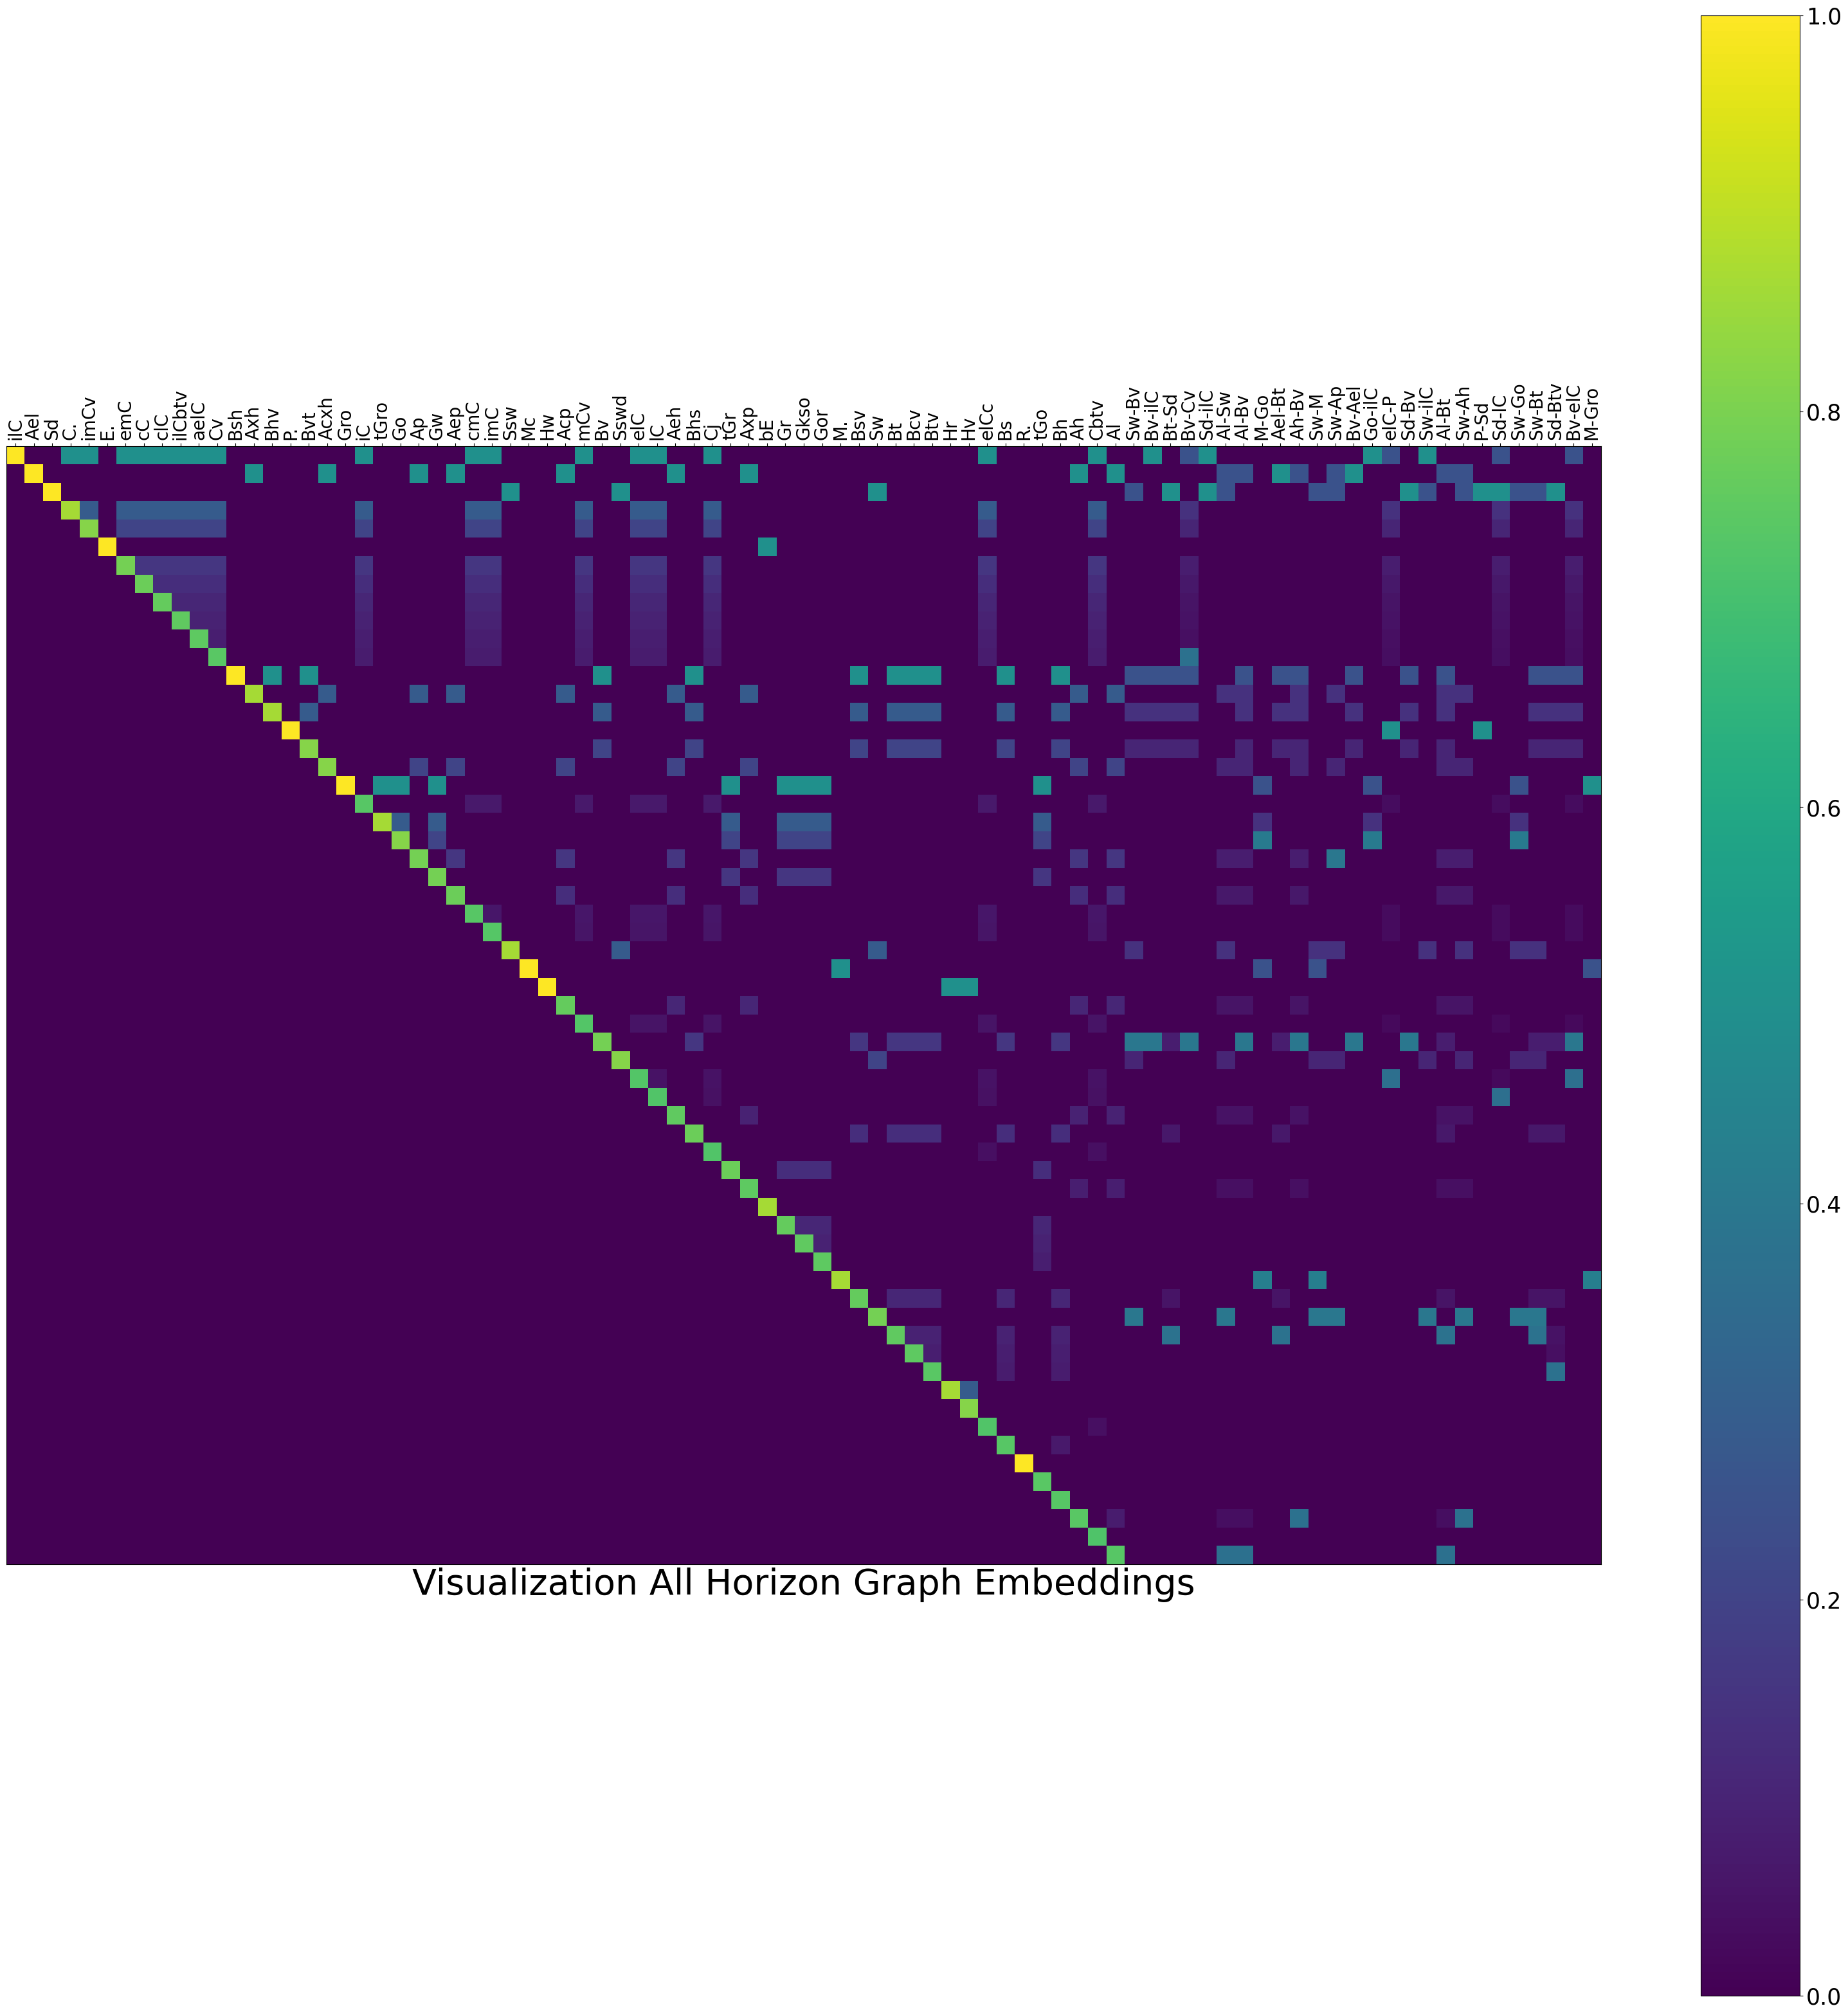

In [69]:
figsize = 40
fontsize = 40
plt.figure(figsize=(figsize,figsize))
plt.imshow(emb_dict['embedding'].T)
plt.xticks(np.arange(len(emb_dict['ind2label'])), emb_dict['ind2label'], rotation=90, fontsize=fontsize-20)
plt.gca().xaxis.set_ticks_position('top')
plt.xlabel('Visualization All Horizon Graph Embeddings', fontsize=fontsize)
plt.yticks([])
cbar = plt.colorbar(); cbar.ax.tick_params(labelsize=fontsize-15)
plt.show()

In [71]:
# Store new dict extended with mixture embeddings
with open('..\\..\\all_horizons_embeddings.pickle', 'wb') as handle:
    pickle.dump(emb_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

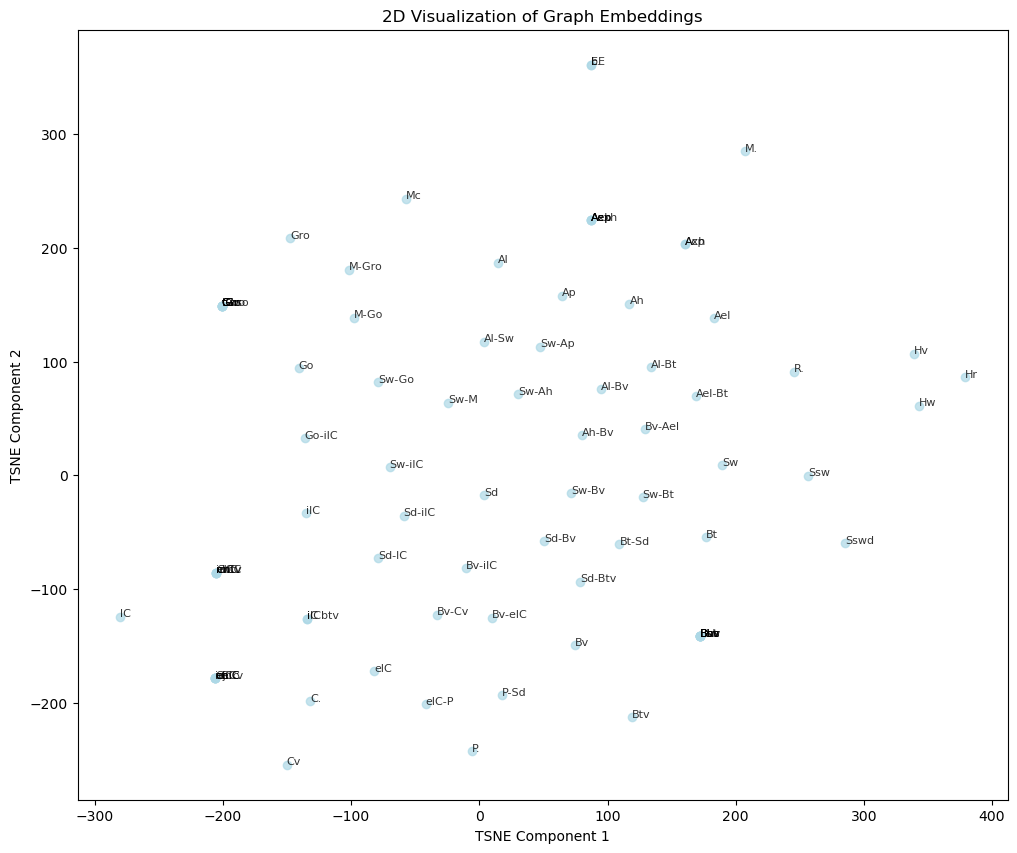

In [78]:
# Reduce dimensions to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(emb_dict['embedding'])

# Plot the embeddings
plt.figure(figsize=(12, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7, c='lightblue')

# Annotate each point with its label
for i, label in enumerate(emb_dict['ind2label']):
  plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], label, fontsize=8, alpha=0.8)

plt.title("2D Visualization of Graph Embeddings")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.show()

#### Verify dot products

##### Vectors from two different main groups

In [79]:
lab1, lab2 = 'Al', 'Bt'
ind1, ind2 = emb_dict['label2ind'][lab1], emb_dict['label2ind'][lab2]
np.dot(emb_dict['embedding'][ind1], emb_dict['embedding'][ind2])

0.0

##### Vectors from the same group (non-mixtures)

In [81]:
lab1, lab2 = 'Bv', 'Bt'
ind1, ind2 = emb_dict['label2ind'][lab1], emb_dict['label2ind'][lab2]
np.dot(emb_dict['embedding'][ind1], emb_dict['embedding'][ind2])

0.5

##### Vectors from the same group (with mixtures)

In [82]:
lab1, lab2 = 'Al-Bt', 'Bt'
ind1, ind2 = emb_dict['label2ind'][lab1], emb_dict['label2ind'][lab2]
np.dot(emb_dict['embedding'][ind1], emb_dict['embedding'][ind2])

0.49999999999999994

In [83]:
lab1, lab2 = 'Al-Bt', 'Al'
ind1, ind2 = emb_dict['label2ind'][lab1], emb_dict['label2ind'][lab2]
np.dot(emb_dict['embedding'][ind1], emb_dict['embedding'][ind2])

0.5

In [84]:
lab1, lab2 = 'Al-Bt', 'Al-Bv'
ind1, ind2 = emb_dict['label2ind'][lab1], emb_dict['label2ind'][lab2]
np.dot(emb_dict['embedding'][ind1], emb_dict['embedding'][ind2])

0.375